In [ ]:
import numpy as np
import pandas as pd

# 1) 파일 로드
df = pd.read_csv("final_monthly.csv")

# 2) 컬럼명 정리
df.columns = df.columns.str.strip()

# 3) 날짜 처리
df['date'] = pd.PeriodIndex(df['date'].astype(str).str.strip(), freq='M')
df = df.sort_values('date').set_index('date')

# 4) 숫자형 변환
for c in df.columns:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.replace(',', '').str.replace('%', '').str.strip(),
        errors='coerce'
    )

# 5) rename 
rename_map = {
    "경제정책 불확실성 지수(EPU)": "epu_index",
    "기준 금리": "bok_rate",
    "뉴스심리지수": "news_sentiment",
    "산업생산지수 갭": "output_gap",
    "산업생산증가율": "ip_growth",
    "인플레이션 갭(소비자물가지수)": "cpi_infl_gap",
    "콜 금리": "call_rate_m",
    "final_monthly_tone": "tone"
}

df = df.rename(columns=rename_map)

print(df.columns.tolist())

# 6) 저장 (이게 진짜 최종본)
df.to_csv("final_monthly_renamed.csv", encoding="utf-8-sig")


['epu_index', 'bok_rate', 'delta_bok', 'news_sentiment', 'output_gap', 'ip_growth', 'cpi_infl_gap', 'call_rate_m', 'tone']


In [13]:
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\eeyy1\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


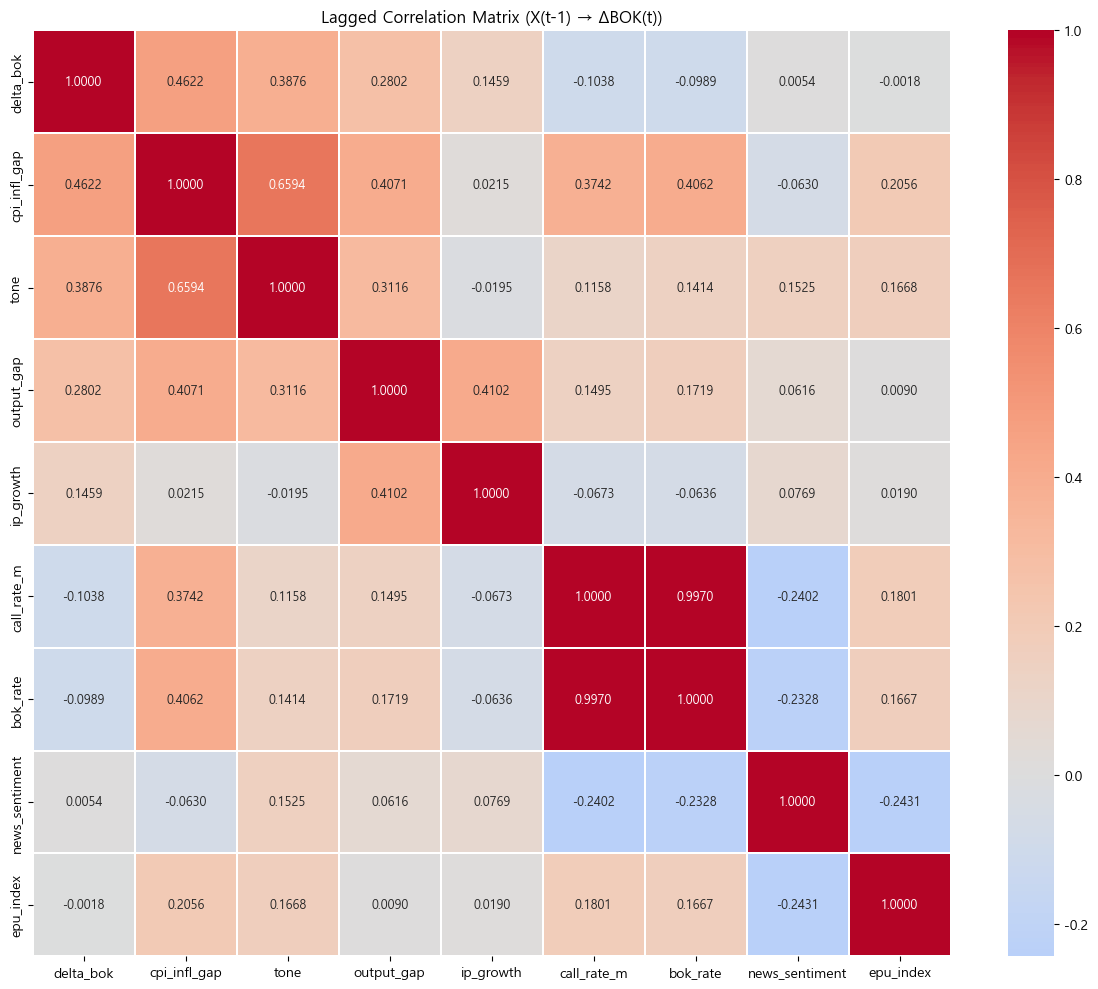


[Correlation with delta_bok | X lagged by 1]
delta_bok         1.000000
cpi_infl_gap      0.462239
tone              0.387577
output_gap        0.280209
ip_growth         0.145917
call_rate_m      -0.103839
bok_rate         -0.098893
news_sentiment    0.005367
epu_index        -0.001844
Name: delta_bok, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ===== 0) 한글 폰트 설정 (Windows 기준) =====
plt.rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 깨짐 방지

# ===== 1) df_lagged 만들기 (네가 하던 로직 그대로) =====
df_final = df_final_renamed.sort_index()
df_num = df_final.select_dtypes(include=[np.number]).copy()

# z_ 제거
z_cols = [c for c in df_num.columns if c.lower().startswith('z_')]
df_num = df_num.drop(columns=z_cols, errors='ignore')

target = 'delta_bok'
feature_cols = [c for c in df_num.columns if c != target]

df_lagged = df_num.copy()
df_lagged[feature_cols] = df_lagged[feature_cols].shift(1)
df_lagged = df_lagged.dropna()

corr_all = df_lagged.corr()

# delta_bok 기준 정렬
order = corr_all[target].abs().sort_values(ascending=False).index
corr_sorted = corr_all.loc[order, order]

# ===== 2) 히트맵 (숫자 표시, 소수점 4자리) =====
plt.figure(figsize=(max(12, 0.8 * len(corr_sorted)), max(10, 0.8 * len(corr_sorted))))
sns.heatmap(
    corr_sorted,
    annot=True,          # 숫자 표시
    fmt=".4f",           # 소수점 4자리
    cmap='coolwarm',
    center=0,
    linewidths=0.3,
    annot_kws={"size": 9}  # 숫자 글씨 크기 (필요시 조절)
)
plt.title('Lagged Correlation Matrix (X(t-1) → ΔBOK(t))')
plt.tight_layout()
plt.show()

# 9) delta_bok 상관만 출력
corr_with_target = corr_all[target].sort_values(key=lambda s: s.abs(), ascending=False)
print("\n[Correlation with delta_bok | X lagged by 1]")
print(corr_with_target)



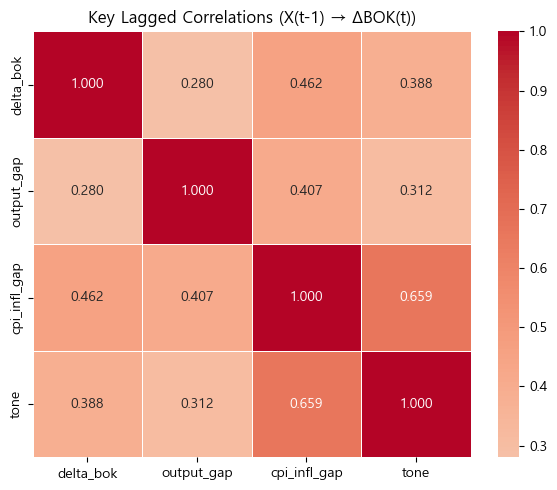

In [34]:
threshold = 0.2

selected_vars = (
    corr_all[target]
    .drop(target)
    .loc[lambda s: s.abs() >= threshold]
    .index
)

selected_vars

heatmap_vars = [target] + list(selected_vars)

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_all.loc[heatmap_vars, heatmap_vars],
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Key Lagged Correlations (X(t-1) → ΔBOK(t))")
plt.tight_layout()
plt.show()


In [29]:
%pip install statsmodels


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\eeyy1\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [42]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def run_final_analysis(df, target_col, feature_cols, maxlags=4):
    """
    t-1 시차 회귀분석 수행:
    - y: target_col (t시점)
    - X: feature_cols를 shift(1) 해서 t-1 정보로 t시점 y를 설명
    - HAC(Newey-West) + White(HC1) 둘 다 출력
    """
    df_ana = df.copy()

    # 0) 컬럼명 공백 방지
    df_ana.columns = df_ana.columns.str.strip()

    # 1) 필요한 컬럼만 숫자형 변환(안전)
    for c in set(feature_cols + [target_col]):
        if c in df_ana.columns:
            df_ana[c] = pd.to_numeric(
                df_ana[c].astype(str).str.replace(',', '').str.replace('%', '').str.strip(),
                errors='coerce'
            )

    # 2) X만 t-1로 shift (y는 그대로)
    df_ana[feature_cols] = df_ana[feature_cols].shift(1)

    # 3) 결측 제거 (shift로 생긴 첫 행 + 원래 결측)
    df_ana = df_ana.dropna(subset=feature_cols + [target_col])

    # 4) 회귀
    X = sm.add_constant(df_ana[feature_cols])
    y = df_ana[target_col]

    model_white = sm.OLS(y, X).fit(cov_type='HC1')
    model_hac = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': maxlags})

    # 5) 결과 표
    rows = []
    for col in X.columns:
        rows.append({
            'Variable': col,
            'Coef(HAC)': float(model_hac.params[col]),     # HAC 계수
            'White_P': float(model_white.pvalues[col]),
            'HAC_P': float(model_hac.pvalues[col])
        })

    out = pd.DataFrame(rows).round(4)

    print(f"=== OLS (X lagged by 1) | R-squared: {model_white.rsquared:.4f} ===")
    print(f"분석 대상 기간: {df_ana.index.min()} ~ {df_ana.index.max()}")
    print(f"HAC maxlags = {maxlags}")
    print("-" * 60)

    return out, model_white, model_hac, df_ana


# ==========================
# 실행부 (유의미 변수만)
# ==========================
target_col = 'delta_bok'

# ✅ 상관분석 결과 기반: |corr| >= 0.2 정도로 의미 있었던 애들
# + 논문처럼 ΔBOK(t-1) 포함
feature_cols = [
    'delta_bok',       # ΔBOK(t-1)
    'cpi_infl_gap',    # 물가 갭
    'output_gap',      # 산출갭
    'tone'             # 톤 지수
]

final_results, model_white, model_hac, df_used = run_final_analysis(
    df_final, target_col, feature_cols, maxlags=4
)

final_results


=== OLS (X lagged by 1) | R-squared: 1.0000 ===
분석 대상 기간: 2012-02 ~ 2025-08
HAC maxlags = 4
------------------------------------------------------------


,Variable,Coef(HAC),White_P,HAC_P
0,const,0.0,0.1141,0.3160
1,delta_bok,1.0,0.0000,0.0000
2,cpi_infl_gap,0.0,0.1292,0.3460
3,output_gap,-0.0,0.0153,0.0492
4,tone,0.0,0.6591,0.7053


=== OLS (X lagged by 1) | R-squared: 0.2346 ===
분석 대상 기간: 2012-02 ~ 2025-08
HAC maxlags = 4
------------------------------------------------------------
=== [RAW] Lag-1 OLS (White R² 기준) ===
기간: 2012-02 ~ 2025-08 | n=164 | R²=1.0000 | Adj R²=1.0000 | HAC maxlags=4

=== [STANDARDIZED X] Lag-1 OLS (White R² 기준) ===
기간: 2012-02 ~ 2025-08 | n=164 | R²=1.0000 | Adj R²=1.0000 | HAC maxlags=4

=== [STANDARDIZED X] tone 제외 모델 ===
기간: 2012-02 ~ 2025-08 | n=166 | R²=1.0000 | Adj R²=1.0000 | HAC maxlags=4

=== tone 포함/제외 R² 비교(White 기준) ===
          Model   R2  Adj_R2    n
0     With tone  1.0     1.0  164
1  Without tone  1.0     1.0  166


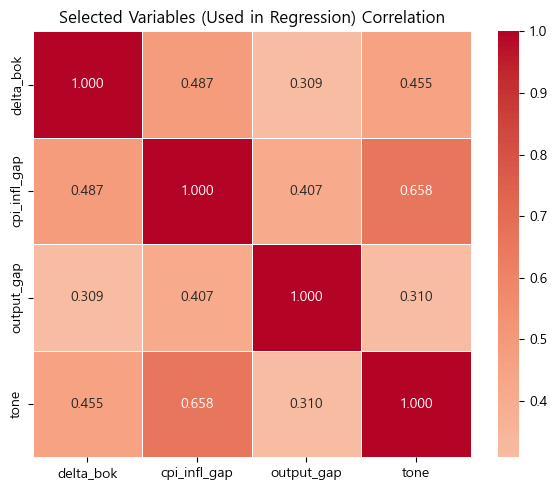

In [44]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def run_final_analysis(df, target_col, feature_cols, maxlags=4):
    """
    t-1 시차 회귀분석 수행:
    - y: target_col (t시점)
    - X: feature_cols를 shift(1) 해서 t-1 정보로 t시점 y를 설명
    - HAC(Newey-West) + White(HC1) 둘 다 출력
    """
    df_ana = df.copy()

    # 0) 컬럼명 공백 방지
    df_ana.columns = df_ana.columns.str.strip()

    # 1) 필요한 컬럼만 숫자형 변환(안전)
    for c in set(feature_cols + [target_col]):
        if c in df_ana.columns:
            df_ana[c] = pd.to_numeric(
                df_ana[c].astype(str).str.replace(',', '').str.replace('%', '').str.strip(),
                errors='coerce'
            )

    # 2) X만 t-1로 shift (y는 그대로)
    df_ana[feature_cols] = df_ana[feature_cols].shift(1)

    # 3) 결측 제거 (shift로 생긴 첫 행 + 원래 결측)
    df_ana = df_ana.dropna(subset=feature_cols + [target_col])

    # 4) 회귀
    X = sm.add_constant(df_ana[feature_cols])
    y = df_ana[target_col]

    model_white = sm.OLS(y, X).fit(cov_type='HC1')
    model_hac = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': maxlags})

    # 5) 결과 표
    rows = []
    for col in X.columns:
        rows.append({
            'Variable': col,
            'Coef(HAC)': float(model_hac.params[col]),     # HAC 계수
            'White_P': float(model_white.pvalues[col]),
            'HAC_P': float(model_hac.pvalues[col])
        })

    out = pd.DataFrame(rows).round(4)

    print(f"=== OLS (X lagged by 1) | R-squared: {model_white.rsquared:.4f} ===")
    print(f"분석 대상 기간: {df_ana.index.min()} ~ {df_ana.index.max()}")
    print(f"HAC maxlags = {maxlags}")
    print("-" * 60)

    return out, model_white, model_hac, df_ana


# ==========================
# 실행부 (유의미 변수만)
# ==========================
target_col = 'delta_bok'

# ✅ 상관분석 결과 기반: |corr| >= 0.2 정도로 의미 있었던 애들
feature_cols = [
    'cpi_infl_gap',    # 물가 갭
    'output_gap',      # 산출갭
    'tone'             # 톤 지수
]

final_results, model_white, model_hac, df_used = run_final_analysis(
    df_final, target_col, feature_cols, maxlags=4
)

final_results

import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# =========================
# 0) (선택) 한글 폰트
# =========================
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


# =========================
# 1) 유틸: 숫자형 안전 변환
# =========================
def _to_numeric_safe(s: pd.Series) -> pd.Series:
    return pd.to_numeric(
        s.astype(str)
         .str.replace(',', '', regex=False)
         .str.replace('%', '', regex=False)
         .str.strip(),
        errors='coerce'
    )


# =========================
# 2) 메인 함수: Lag-1 OLS + (White/HAC) + 옵션 표준화
# =========================
def run_final_analysis(
    df: pd.DataFrame,
    target_col: str,
    feature_cols: list,
    maxlags: int = 4,
    standardize_cols = None,  # 표준화할 X 컬럼들(=feature_cols 중 일부)
    digits: int = 6                        # 출력 소수 자리
):
    """
    t-1 시차 회귀분석:
    - y: target_col (t)
    - X: feature_cols를 shift(1) 해서 X(t-1)로 y(t) 설명
    - 표준화 옵션: standardize_cols에 지정된 X만 z-score
    - White(HC1) / HAC(Newey-West) 둘 다 산출
    """
    df_ana = df.copy()
    df_ana.columns = df_ana.columns.str.strip()

    # 1) 필요한 컬럼 숫자형 변환
    need_cols = list(set(feature_cols + [target_col]))
    for c in need_cols:
        if c in df_ana.columns:
            df_ana[c] = _to_numeric_safe(df_ana[c])

    # 2) X만 lag1
    df_ana[feature_cols] = df_ana[feature_cols].shift(1)

    # 3) 결측 제거
    df_ana = df_ana.dropna(subset=feature_cols + [target_col]).copy()

    # 4) (옵션) X 표준화: 지정된 컬럼만
    if standardize_cols is not None and len(standardize_cols) > 0:
        for c in standardize_cols:
            if c in df_ana.columns:
                std = df_ana[c].std(ddof=0)
                if std == 0 or np.isnan(std):
                    # 분산 0이면 표준화 불가 → 그대로 둠
                    continue
                df_ana[c] = (df_ana[c] - df_ana[c].mean()) / std

    # 5) 회귀
    X = sm.add_constant(df_ana[feature_cols])
    y = df_ana[target_col]

    model_white = sm.OLS(y, X).fit(cov_type='HC1')
    model_hac   = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': maxlags})

    # 6) 결과표(계수는 HAC 기준 + pvalue 둘 다)
    rows = []
    for col in X.columns:
        rows.append({
            "Variable": col,
            "Coef(HAC)": float(model_hac.params[col]),
            "White_P": float(model_white.pvalues[col]),
            "HAC_P": float(model_hac.pvalues[col])
        })

    out = pd.DataFrame(rows).round(digits)

    info = {
        "nobs": int(model_white.nobs),
        "r2": float(model_white.rsquared),
        "adj_r2": float(model_white.rsquared_adj),
        "start": df_ana.index.min(),
        "end": df_ana.index.max(),
        "maxlags": maxlags
    }

    return out, model_white, model_hac, df_ana, info


# =========================
# 3) 실행부
# =========================
# df_final 은 네가 이미 만들어둔 "df_final_renamed.sort_index()" 같은 최종 DF라고 가정
df_final = df_final_renamed.sort_index()

target_col = "delta_bok"

# (추천) 상관분석 기반 선별 변수 + ΔBOK(t-1) 포함
feature_cols_selected = [
    "delta_bok",      # ΔBOK(t-1)  (shift(1)로 구현)
    "cpi_infl_gap",
    "output_gap",
    "tone"
]

# -------------------------
# A) 원단위(비표준화) 회귀
# -------------------------
res_raw, mW_raw, mH_raw, df_used_raw, info_raw = run_final_analysis(
    df=df_final,
    target_col=target_col,
    feature_cols=feature_cols_selected,
    maxlags=4,
    standardize_cols=None,
    digits=6
)

print("=== [RAW] Lag-1 OLS (White R² 기준) ===")
print(f"기간: {info_raw['start']} ~ {info_raw['end']} | n={info_raw['nobs']} | R²={info_raw['r2']:.4f} | Adj R²={info_raw['adj_r2']:.4f} | HAC maxlags={info_raw['maxlags']}")
res_raw


# -------------------------
# B) 표준화 회귀 (해석용 추천)
#   - ΔBOK(t-1)은 그대로 두고
#   - 거시/톤 변수만 표준화
# -------------------------
standardize_cols = ["cpi_infl_gap", "output_gap", "tone"]

res_std, mW_std, mH_std, df_used_std, info_std = run_final_analysis(
    df=df_final,
    target_col=target_col,
    feature_cols=feature_cols_selected,
    maxlags=4,
    standardize_cols=standardize_cols,
    digits=6
)

print("\n=== [STANDARDIZED X] Lag-1 OLS (White R² 기준) ===")
print(f"기간: {info_std['start']} ~ {info_std['end']} | n={info_std['nobs']} | R²={info_std['r2']:.4f} | Adj R²={info_std['adj_r2']:.4f} | HAC maxlags={info_std['maxlags']}")
res_std


# -------------------------
# C) (핵심 비교) tone 제외 모델도 같이 돌려서
#    tone의 추가 설명력 비교
# -------------------------
feature_cols_no_tone = [
    "delta_bok",
    "cpi_infl_gap",
    "output_gap"
]

res_std_no_tone, mW_std_no_tone, mH_std_no_tone, df_used_std_no_tone, info_std_no_tone = run_final_analysis(
    df=df_final,
    target_col=target_col,
    feature_cols=feature_cols_no_tone,
    maxlags=4,
    standardize_cols=["cpi_infl_gap", "output_gap"],  # tone 없으니 얘네만
    digits=6
)

print("\n=== [STANDARDIZED X] tone 제외 모델 ===")
print(f"기간: {info_std_no_tone['start']} ~ {info_std_no_tone['end']} | n={info_std_no_tone['nobs']} | R²={info_std_no_tone['r2']:.4f} | Adj R²={info_std_no_tone['adj_r2']:.4f} | HAC maxlags={info_std_no_tone['maxlags']}")
res_std_no_tone


print("\n=== tone 포함/제외 R² 비교(White 기준) ===")
print(pd.DataFrame([
    {"Model": "With tone", "R2": info_std["r2"], "Adj_R2": info_std["adj_r2"], "n": info_std["nobs"]},
    {"Model": "Without tone", "R2": info_std_no_tone["r2"], "Adj_R2": info_std_no_tone["adj_r2"], "n": info_std_no_tone["nobs"]}
]).round(4))


# =========================
# 4) (옵션) 회귀에 실제 사용된 데이터 기준 히트맵
# =========================
heatmap_vars = [target_col] + feature_cols_selected  # target 포함(중복되면 상관행렬에서 문제는 없음)
heatmap_vars = list(dict.fromkeys(heatmap_vars))     # 중복 제거

corr_small = df_used_std[heatmap_vars].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_small, annot=True, fmt=".3f", cmap="coolwarm", center=0, linewidths=0.4)
plt.title("Selected Variables (Used in Regression) Correlation")
plt.tight_layout()
plt.show()



=== [RAW] y(t)=ΔBOK, X(t-1) ===
기간: 2012-02 ~ 2025-08 | n=163 | R²=0.2346 | Adj R²=0.2202 | HAC maxlags=4

=== [STD] y(t)=ΔBOK, X(t-1) (X 표준화) ===
기간: 2012-02 ~ 2025-08 | n=163 | R²=0.2346 | Adj R²=0.2202 | HAC maxlags=4

=== tone 포함/제외 R² 비교(White 기준) ===
          Model      R2  Adj_R2    n
0     With tone  0.2346  0.2202  163
1  Without tone  0.2237  0.2141  165


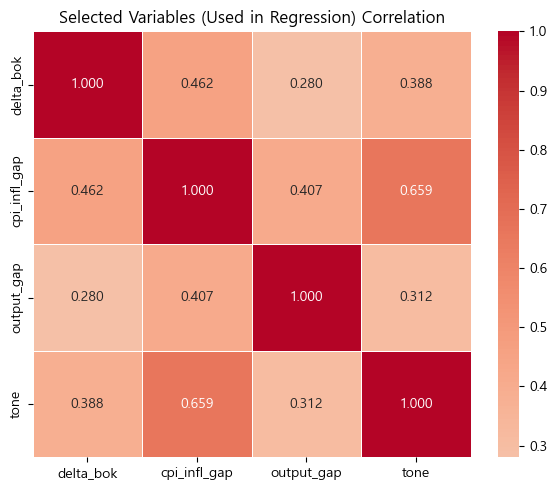


[RAW coef table | HAC p-value 기준]


,Variable,Coef(HAC),White_P,HAC_P,Sig
0,const,-0.000085,0.992154,0.992503,
1,cpi_infl_gap,0.029107,0.003532,0.002500,***
2,output_gap,0.009842,0.177104,0.149200,
3,tone,0.048173,0.056854,0.036623,**



[STD coef table | HAC p-value 기준]  (해석은 이걸로 추천)


,Variable,Coef(HAC),White_P,HAC_P,Sig
0,const,-0.004601,0.577388,0.590385,
1,cpi_infl_gap,0.039142,0.003532,0.002500,***
2,output_gap,0.012279,0.177104,0.149200,
3,tone,0.016493,0.056854,0.036623,**



[STD | 영향력(절댓값) 순 정렬]


,Variable,Coef(HAC),HAC_P
1,cpi_infl_gap,0.039142,0.002500
3,tone,0.016493,0.036623
2,output_gap,0.012279,0.149200


In [46]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# (선택) 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


# =========================
# 1) 유틸: 숫자형 안전 변환
# =========================
def to_numeric_safe(s: pd.Series) -> pd.Series:
    return pd.to_numeric(
        s.astype(str)
         .str.replace(',', '', regex=False)
         .str.replace('%', '', regex=False)
         .str.strip(),
        errors='coerce'
    )


# =========================
# 2) Lag-1 회귀 함수 (옵션: 표준화)
# =========================
def run_lag1_ols(df, target_col, feature_cols, maxlags=4, standardize_cols=None, digits=6):
    """
    y(t) ~ X(t-1)
    - feature_cols만 shift(1)
    - White(HC1) / HAC(Newey-West) p-value 같이 제공
    - standardize_cols: X 중 일부만 z-score 표준화(해석용)
    """
    df_ana = df.copy()
    df_ana.columns = df_ana.columns.str.strip()

    # 필요한 컬럼만 숫자 변환
    need_cols = list(set([target_col] + feature_cols))
    for c in need_cols:
        if c in df_ana.columns:
            df_ana[c] = to_numeric_safe(df_ana[c])

    # X만 lag1
    df_ana[feature_cols] = df_ana[feature_cols].shift(1)

    # 결측 제거
    df_ana = df_ana.dropna(subset=[target_col] + feature_cols).copy()

    # (옵션) 표준화
    if standardize_cols:
        for c in standardize_cols:
            if c in df_ana.columns:
                std = df_ana[c].std(ddof=0)
                if std and not np.isnan(std) and std != 0:
                    df_ana[c] = (df_ana[c] - df_ana[c].mean()) / std

    # 회귀
    X = sm.add_constant(df_ana[feature_cols])
    y = df_ana[target_col]

    model_white = sm.OLS(y, X).fit(cov_type='HC1')
    model_hac   = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': maxlags})

    # 결과표
    out = pd.DataFrame({
        "Variable": X.columns,
        "Coef(HAC)": [float(model_hac.params[c]) for c in X.columns],
        "White_P":   [float(model_white.pvalues[c]) for c in X.columns],
        "HAC_P":     [float(model_hac.pvalues[c]) for c in X.columns],
    }).round(digits)

    info = {
        "n": int(model_white.nobs),
        "r2": float(model_white.rsquared),
        "adj_r2": float(model_white.rsquared_adj),
        "start": df_ana.index.min(),
        "end": df_ana.index.max(),
        "maxlags": maxlags
    }

    return out, model_white, model_hac, df_ana, info


# =========================
# 3) 실행부
# =========================
df_final = df_final_renamed.sort_index()

target_col = "delta_bok"

# ✅ 메인(추천): delta_bok(t-1) 제외
feature_cols = ["cpi_infl_gap", "output_gap", "tone"]

# ---- A) RAW ----
res_raw, mW_raw, mH_raw, df_used_raw, info_raw = run_lag1_ols(
    df_final, target_col, feature_cols,
    maxlags=4, standardize_cols=None, digits=6
)
print("=== [RAW] y(t)=ΔBOK, X(t-1) ===")
print(f"기간: {info_raw['start']} ~ {info_raw['end']} | n={info_raw['n']} | R²={info_raw['r2']:.4f} | Adj R²={info_raw['adj_r2']:.4f} | HAC maxlags={info_raw['maxlags']}")
res_raw


# ---- B) Standardized X (해석용) ----
res_std, mW_std, mH_std, df_used_std, info_std = run_lag1_ols(
    df_final, target_col, feature_cols,
    maxlags=4, standardize_cols=feature_cols, digits=6
)
print("\n=== [STD] y(t)=ΔBOK, X(t-1) (X 표준화) ===")
print(f"기간: {info_std['start']} ~ {info_std['end']} | n={info_std['n']} | R²={info_std['r2']:.4f} | Adj R²={info_std['adj_r2']:.4f} | HAC maxlags={info_std['maxlags']}")
res_std


# ---- C) (옵션) tone 제외 비교 ----
feature_cols_no_tone = ["cpi_infl_gap", "output_gap"]

res_std_no_tone, mW_std_no_tone, mH_std_no_tone, df_used_std_no_tone, info_std_no_tone = run_lag1_ols(
    df_final, target_col, feature_cols_no_tone,
    maxlags=4, standardize_cols=feature_cols_no_tone, digits=6
)

print("\n=== tone 포함/제외 R² 비교(White 기준) ===")
print(pd.DataFrame([
    {"Model": "With tone", "R2": info_std["r2"], "Adj_R2": info_std["adj_r2"], "n": info_std["n"]},
    {"Model": "Without tone", "R2": info_std_no_tone["r2"], "Adj_R2": info_std_no_tone["adj_r2"], "n": info_std_no_tone["n"]},
]).round(4))


# ---- D) (옵션) 회귀에 사용된 데이터 기준 상관 히트맵 ----
corr_small = df_used_std[[target_col] + feature_cols].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_small, annot=True, fmt=".3f", cmap="coolwarm", center=0, linewidths=0.4)
plt.title("Selected Variables (Used in Regression) Correlation")
plt.tight_layout()
plt.show()

# =========================
# E) coef 표(논문 스타일) 보기 좋게 출력
# =========================
def add_stars(p):
    if p < 0.01:
        return "***"
    elif p < 0.05:
        return "**"
    elif p < 0.10:
        return "*"
    else:
        return ""

def pretty_coef_table(res_df, pcol="HAC_P"):
    out = res_df.copy()
    out["Sig"] = out[pcol].apply(add_stars)
    out["Coef_sig"] = out["Coef(HAC)"].astype(str) + out["Sig"]
    # 보기 좋은 컬럼만
    out = out[["Variable", "Coef(HAC)", "White_P", "HAC_P", "Sig"]]
    return out

print("\n[RAW coef table | HAC p-value 기준]")
display(pretty_coef_table(res_raw, pcol="HAC_P"))

print("\n[STD coef table | HAC p-value 기준]  (해석은 이걸로 추천)")
display(pretty_coef_table(res_std, pcol="HAC_P"))

# 표준화 계수(절댓값) 기준 영향력 순서 확인
impact_rank = (
    res_std.query("Variable != 'const'")
           .assign(abs_coef=lambda d: d["Coef(HAC)"].abs())
           .sort_values("abs_coef", ascending=False)
           [["Variable", "Coef(HAC)", "HAC_P"]]
)
print("\n[STD | 영향력(절댓값) 순 정렬]")
display(impact_rank)


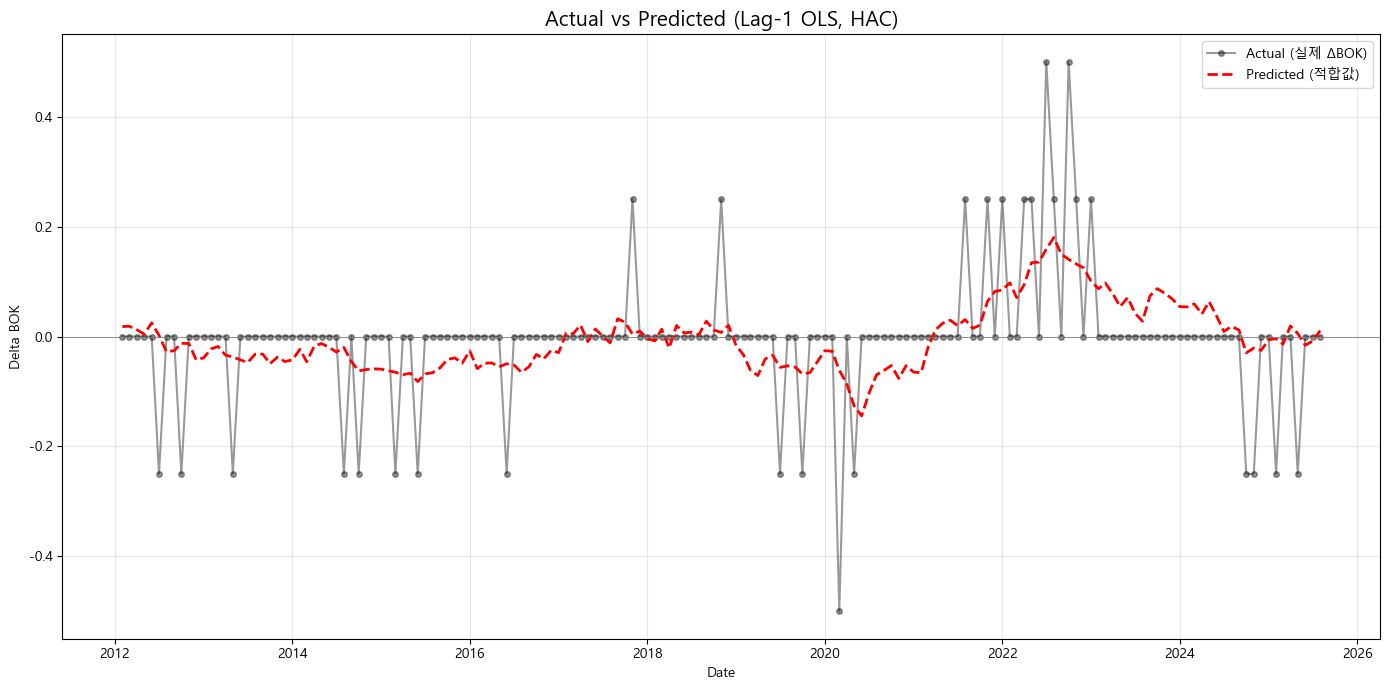

[예측 오차] MAE = 0.071093 | RMSE = 0.104126
최종 분석 결과(163건)가 'final_analysis_result_lagged.csv'로 저장되었습니다!


In [53]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

# ✅ 네가 이미 돌린 회귀 결과에서 가져오기
best_model = mH_raw          # HAC 모델
df_ana = df_used_raw         # lag1 적용 + dropna까지 끝난 데이터
feature_cols_our = feature_cols
# target_col 은 이미 "delta_bok"으로 설정되어 있음

# 1) 예측용 X/y (훈련과 동일한 데이터 기준)
X_final = sm.add_constant(df_ana[feature_cols_our], has_constant="add")
y_actual = df_ana[target_col]

# 2) 예측치(적합값) 계산
df_ana = df_ana.copy()
df_ana["predicted_delta"] = best_model.predict(X_final)

# 3) 시각화
# x축을 Period -> Timestamp로 변환 (matplotlib 호환)
x = df_ana.index.to_timestamp()

plt.figure(figsize=(14, 7))

plt.plot(
    x, y_actual.values,
    label="Actual (실제 ΔBOK)",
    color="black", marker="o", markersize=4, alpha=0.4
)

plt.plot(
    x, df_ana["predicted_delta"].values,
    label="Predicted (적합값)",
    color="red", linestyle="--", linewidth=2
)

plt.title("Actual vs Predicted (Lag-1 OLS, HAC)", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Delta BOK")
plt.axhline(0, color="gray", linewidth=0.6)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 4) 오차 지표
mae = np.mean(np.abs(y_actual - df_ana["predicted_delta"]))
rmse = np.sqrt(np.mean((y_actual - df_ana["predicted_delta"])**2))
print(f"[예측 오차] MAE = {mae:.6f} | RMSE = {rmse:.6f}")

# 5) 저장
out_path = "final_analysis_result_lagged.csv"
df_ana.to_csv(out_path, encoding="utf-8-sig")
print(f"최종 분석 결과({len(df_ana)}건)가 '{out_path}'로 저장되었습니다!")


In [51]:
# ============================================================
# 1) (셀 2) Our Model 예측/그래프/저장
# - df_final, best_model, target_col 이 이미 존재한다고 가정
# - feature_cols_our는 rename된 컬럼명 기준으로 재정의
# ============================================================

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 타깃
target_col = "delta_bok"

# ✅ rename된 컬럼 기준 Our Model X(t-1)
feature_cols_our = [
    "cpi_infl_gap",
    "output_gap",
    "tone"
]

# --- df_ana 재구성: X만 lag1 적용 ---
df_ana = df_final.copy()

# 안전 숫자 변환
for c in [target_col] + feature_cols_our:
    df_ana[c] = pd.to_numeric(df_ana[c], errors="coerce")

# lag 1 적용 (독립변수만)
df_ana[feature_cols_our] = df_ana[feature_cols_our].shift(1)

# 결측 제거
df_ana = df_ana.dropna(subset=[target_col] + feature_cols_our).copy()

# --- 예측 ---
X_final = sm.add_constant(df_ana[feature_cols_our], has_constant="add")
y_actual = df_ana[target_col]

df_ana["predicted_delta"] = best_model.predict(X_final)

# --- 그래프 ---
plt.figure(figsize=(14, 7))

plt.plot(
    df_ana.index, y_actual,
    label="Actual (실제 ΔBOK)",
    color="black", marker="o", markersize=4, alpha=0.4
)

plt.plot(
    df_ana.index, df_ana["predicted_delta"],
    label="Predicted (모델 예측치)",
    color="red", linestyle="--", linewidth=2
)

plt.title("금리 변동 예측 성능: Actual vs Predicted (Lag-1 Model)", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Delta BOK")
plt.axhline(0, color="gray", linewidth=0.6)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- 오차 지표 ---
mae = np.mean(np.abs(y_actual - df_ana["predicted_delta"]))
rmse = np.sqrt(np.mean((y_actual - df_ana["predicted_delta"])**2))
print(f"[예측 오차] MAE = {mae:.6f} | RMSE = {rmse:.6f}")

# --- 저장 ---
out_path = "final_analysis_result_lagged.csv"
df_ana.to_csv(out_path, encoding="utf-8-sig")
print(f"최종 분석 결과({len(df_ana)}건)가 '{out_path}'로 저장되었습니다!")


NameError: name 'best_model' is not defined